# Churn model for Insurance Company

The first attempt will be to try to predict the drivers of churn based on a classification method. The data contains flags relevant to customers demographics, claim and service behaviour and policy characteristics.

In [1]:
import pandas as pd

###### ** Changes from dataset version 2 to version 6:**

The data source had to be changed in order to address few issues/opportunities:
- the field AvgTurnaround had too many null values. Considering that only customers who claim will have this information, I couldn't find a way to keep the information in. So, for this reason it has been excluded from the datased
- the field CXMonthsFromRenewal also contained too many null values. The objective of the field is to provide the number of months that the policy is in the policy period, which expires every 12 months. There is a hypothesis that indicates that the customers are more likely to cancel when their policy is about to expiry
- the data size - reduce to only use policies with 0 to 5 years of tenure
- added data about latest claim and further demographics

In [7]:
policies = pd.read_table('ChurnModelDatasetV6.txt',index_col='no_')

In [8]:
### policies.shape
#policies.values            # underlying numpy array
policies.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267377 entries, 459905 to 393303
Data columns (total 37 columns):
Cancelled                      267377 non-null int64
PlanType                       267377 non-null object
ClaimedInThePast               267377 non-null int64
BenefitToClaimRatio            267377 non-null float64
irsd_decile                    265673 non-null float64
premium payment period code    267377 non-null object
payment method code            267377 non-null object
InsuredGender                  267377 non-null object
premium                        267377 non-null float64
PremiumDecile                  267377 non-null int64
breed risk group               267377 non-null int64
CXMonthsFromRenewal            267377 non-null int64
TenureInMonths                 267377 non-null int64
PetAgeInMonths                 267377 non-null int64
ClientAgeInMonths              267377 non-null int64
SalesChannel                   267377 non-null object
pet agegroup when join   

**Interpreting the quantiles**
- Ntile5LastClaimAmount - 5 tile, 1 = lowest value
- Ntile5LastPaidAmount - 5 tile, 1 = lowest value
- PremiumDecile - 10 tile, 1 = lowest value

In [9]:
## remove columns that won't be used
policies.columns = [c.replace(' ', '_') for c in policies.columns]
policies.drop('premium', axis=1, inplace=True)
policies.drop('ClientAgeInMonths', axis=1, inplace=True)
policies.drop('PetAgeInMonths', axis=1, inplace=True)
policies.drop('petAgeInYears', axis=1, inplace=True)
policies.drop('ClientAgeInYears', axis=1, inplace=True)
policies.drop('Insured_Gender', axis=1, inplace=True)
policies.drop('Brand',axis=1,inplace=True)
policies.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267377 entries, 459905 to 393303
Data columns (total 30 columns):
Cancelled                      267377 non-null int64
PlanType                       267377 non-null object
ClaimedInThePast               267377 non-null int64
BenefitToClaimRatio            267377 non-null float64
irsd_decile                    265673 non-null float64
premium_payment_period_code    267377 non-null object
payment_method_code            267377 non-null object
InsuredGender                  267377 non-null object
PremiumDecile                  267377 non-null int64
breed_risk_group               267377 non-null int64
CXMonthsFromRenewal            267377 non-null int64
TenureInMonths                 267377 non-null int64
SalesChannel                   267377 non-null object
pet_agegroup_when_join         267377 non-null object
client_agegroup_when_join      267377 non-null object
NumberCalls                    267377 non-null int64
ClaimReviews             

In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot') # This styles the graphs in a nicer format

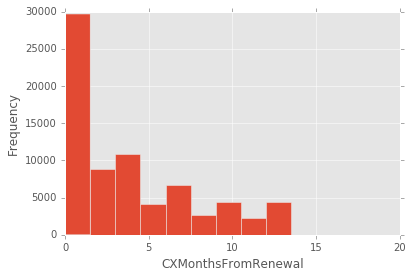

In [11]:
policies[policies.Cancelled == 1].CXMonthsFromRenewal.plot(kind='hist', xlim=(0,20))
#policies.CXMonthsFromRenewal.hist(by=policies.Cancelled, sharex=True, sharey=True)
plt.xlabel('CXMonthsFromRenewal')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 267377 entries, 459905 to 393303
Data columns (total 30 columns):
Cancelled                      267377 non-null int64
PlanType                       267377 non-null object
ClaimedInThePast               267377 non-null int64
BenefitToClaimRatio            267377 non-null float64
irsd_decile                    265673 non-null float64
premium_payment_period_code    267377 non-null object
payment_method_code            267377 non-null object
InsuredGender                  267377 non-null object
PremiumDecile                  267377 non-null int64
breed_risk_group               267377 non-null int64
CXMonthsFromRenewal            267377 non-null int64
TenureInMonths                 267377 non-null int64
SalesChannel                   267377 non-null object
pet_agegroup_when_join         267377 non-null object
client_agegroup_when_join      267377 non-null object
NumberCalls                    267377 non-null int64
ClaimReviews             

01-02     65676
02-03     49316
00-01     49113
03-04     24473
04-05     18301
05-06     15230
06-07     12523
07-08      9971
08-09      8438
09-10      5603
11-100     5359
10-11      3374
Name: PetAgeGroup, dtype: int64

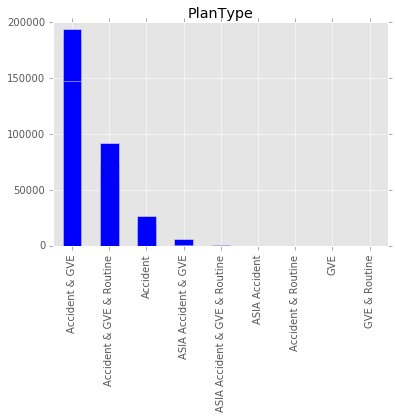

In [13]:
#transforming the string values into numeric values

policies.LastClaimStatus.value_counts().plot(kind='bar', title='Last Claim Status')
policies.InsuredGender.value_counts().plot(kind='bar', title='Gender')
policies.PlanType.value_counts().plot(kind='bar',title='PlanType')
policies.PlanType.value_counts()
policies.info()
policies.premium_payment_period_code.value_counts()
policies.payment_method_code.value_counts()
policies.species_code.value_counts()
policies.State.value_counts()
policies.ClientAgeInGroup.value_counts()
policies.PetAgeGroup.value_counts()

In [14]:
policies.LastClaimStatus.replace(['No Claims', 'Accepted with Pay', 'Denied', 'Accepted no Pay', 'Other'],  [1, 2, 3, 4, 0], inplace=True)
policies.InsuredGender.replace(['Female', 'Male'], [1, 2], inplace=True)
policies.PlanType.replace(['Accident & GVE', 'Accident & GVE & Routine','Accident','ASIA Accident & GVE',
                         'ASIA Accident & GVE & Routine','ASIA Accident','Accident & Routine','GVE & Routine','GVE'], 
                          [1, 2,3,1,2,3,4,4,4], inplace=True)
policies.premium_payment_period_code.replace(['FORTNIGHTL','MONTHLY','ANNUALLY'],[1,2,3], inplace=True)
policies.payment_method_code.replace(['CC','BANK','CHEQUE'],[1,2,3], inplace=True)
policies.species_code.replace(['CANINE','FELINE'],[1,2], inplace=True)
policies.State.replace(['NSW','VIC','QLD','WA','SA','ACT','TAS','NT'],[1,2,3,4,5,6,7,8], inplace=True)
policies.ClientAgeInGroup.replace(['00-19','20-29','30-39','40-49','50-59','60-100'],[1,2,3,4,5,6],inplace=True)
policies.PetAgeGroup.replace(['00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-100'],[1,2,3,4,5,6,7,8,9,10,11,12],inplace=True)     
policies.Cancelled.value_counts()
policies.describe()

,Cancelled,PlanType,ClaimedInThePast,BenefitToClaimRatio,irsd_decile,premium_payment_period_code,payment_method_code,InsuredGender,PremiumDecile,breed_risk_group,...,OtherMembershipNumber,species_code,State,OtherPets,MOnthsSinceLastClaim,LastClaimStatus,Ntile5LastClaimAmount,Ntile5LastPaidAmount,ClientAgeInGroup,PetAgeGroup
count,267377.000000,267377.000000,267377.000000,267377.000000,265673.000000,267377.000000,267377.000000,267377.000000,267377.000000,267377.000000,...,267377.000000,267377.000000,267377.000000,267377.000000,267377.000000,267377.000000,267377.000000,267377.000000,267377.000000,267377.000000
mean,0.275981,1.546580,0.306204,0.115297,6.564901,1.563680,1.449343,1.272477,5.500054,0.683806,...,0.273573,1.154901,2.736570,0.818664,7.914151,1.412032,0.773298,0.941936,3.705711,3.777486
std,0.447008,0.670427,0.460917,0.235960,2.699836,0.675772,0.497458,0.445235,2.872324,1.506435,...,0.445793,0.361811,1.508266,1.548938,7.255200,0.714168,1.370540,1.654290,1.330281,2.744004
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,-23.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,1.000000,0.000000,0.000000,4.000000,1.000000,1.000000,1.000000,3.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,3.000000,2.000000
50%,0.000000,1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,1.000000,6.000000,0.000000,...,0.000000,1.000000,3.000000,0.000000,6.000000,1.000000,0.000000,0.000000,4.000000,3.000000
75%,1.000000,2.000000,1.000000,0.000000,9.000000,2.000000,2.000000,2.000000,8.000000,0.000000,...,1.000000,1.000000,4.000000,1.000000,12.000000,2.000000,1.000000,1.000000,5.000000,5.000000
max,1.000000,4.000000,1.000000,1.100062,10.000000,3.000000,3.000000,2.000000,10.000000,6.000000,...,1.000000,2.000000,8.000000,33.000000,37.000000,4.000000,5.000000,5.000000,6.000000,12.000000


**From String to values**
- LastClaimStatus: No Claims = 1, Accepted with Pay = 2, Denied = 3, Accepted no Pay = 4, Other = 0
- InsuredGender: Female = 1, Male = 2
- PlanType: Accident & GVE = 1, Accident & GVE & Routine = 2, Accident = 3, ASIA Accident & GVE = 1, ASIA Accident & GVE & Routine = 2, ASIA Accident = 3, Accident & Routine =4, GVE & Routine = 4, GVE = 4
- premium_payment_period_code: FORTNIGHTL = 1, MONTHLY = 2, ANNUALLY = 3
- payment_method_code: CC = 1, BANK = 2, CHEQUE = 3
- species_code: CANINE = 1, FELINE = 2
- State: NSW = 1, VIC = 2, QLD = 3, WA = 4, SA = 5, ACT = 6, TAS = 7, NT = 8
- ClientAgeInGroup: 00-19 = 1, 20-29 = 2, 30-39 = 3, 40-49 = 4, 50-59 = 5, 60-100 = 6
- PetAgeGroup: 00-01 = 1, 01-02 = 2, 02-03 = 3, 03-04 = 4, 04-05 = 5, 05-06 = 6, 06-07 = 7, 07-08 = 8, 08-09 = 9, 09-10 = 10, 10-11 = 11, 11-100 = 12

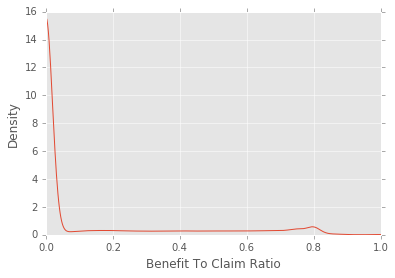

In [15]:
policies.BenefitToClaimRatio.plot(kind='density', xlim=(0,1))
plt.xlabel('Benefit To Claim Ratio')

In [16]:
policies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267377 entries, 459905 to 393303
Data columns (total 30 columns):
Cancelled                      267377 non-null int64
PlanType                       267377 non-null int64
ClaimedInThePast               267377 non-null int64
BenefitToClaimRatio            267377 non-null float64
irsd_decile                    265673 non-null float64
premium_payment_period_code    267377 non-null int64
payment_method_code            267377 non-null int64
InsuredGender                  267377 non-null int64
PremiumDecile                  267377 non-null int64
breed_risk_group               267377 non-null int64
CXMonthsFromRenewal            267377 non-null int64
TenureInMonths                 267377 non-null int64
SalesChannel                   267377 non-null object
pet_agegroup_when_join         267377 non-null object
client_agegroup_when_join      267377 non-null object
NumberCalls                    267377 non-null int64
ClaimReviews                 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x113e0c690>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11dfac7d0>], dtype=object)

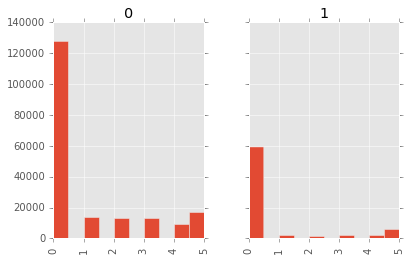

In [17]:
policies.Ntile5LastPaidAmount.hist(by=policies.Cancelled, sharex=True, sharey=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11ded09d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1162e4610>], dtype=object)

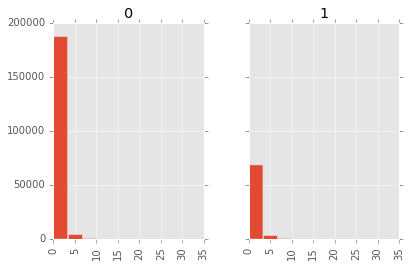

In [18]:
policies.OtherPets.hist(by=policies.Cancelled, sharex=True, sharey=True)

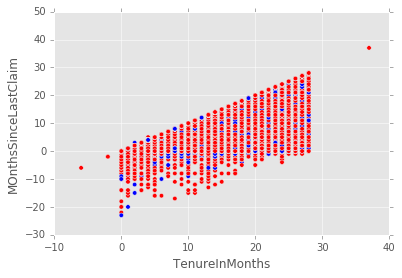

In [20]:
colors = np.where(policies.species_code==1, 'r', 'b') #canine red
policies.plot(kind='scatter', x='TenureInMonths', y='MOnthsSinceLastClaim', c=colors)

In [ ]:
#pd.scatter_matrix(policies, figsize=(30,30))

In [21]:
import statsmodels.formula.api as smf

In [22]:
policies.describe()

,Cancelled,PlanType,ClaimedInThePast,BenefitToClaimRatio,irsd_decile,premium_payment_period_code,payment_method_code,InsuredGender,PremiumDecile,breed_risk_group,...,OtherMembershipNumber,species_code,State,OtherPets,MOnthsSinceLastClaim,LastClaimStatus,Ntile5LastClaimAmount,Ntile5LastPaidAmount,ClientAgeInGroup,PetAgeGroup
count,267377.000000,267377.000000,267377.000000,267377.000000,265673.000000,267377.000000,267377.000000,267377.000000,267377.000000,267377.000000,...,267377.000000,267377.000000,267377.000000,267377.000000,267377.000000,267377.000000,267377.000000,267377.000000,267377.000000,267377.000000
mean,0.275981,1.546580,0.306204,0.115297,6.564901,1.563680,1.449343,1.272477,5.500054,0.683806,...,0.273573,1.154901,2.736570,0.818664,7.914151,1.412032,0.773298,0.941936,3.705711,3.777486
std,0.447008,0.670427,0.460917,0.235960,2.699836,0.675772,0.497458,0.445235,2.872324,1.506435,...,0.445793,0.361811,1.508266,1.548938,7.255200,0.714168,1.370540,1.654290,1.330281,2.744004
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,-23.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,1.000000,0.000000,0.000000,4.000000,1.000000,1.000000,1.000000,3.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,3.000000,2.000000
50%,0.000000,1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,1.000000,6.000000,0.000000,...,0.000000,1.000000,3.000000,0.000000,6.000000,1.000000,0.000000,0.000000,4.000000,3.000000
75%,1.000000,2.000000,1.000000,0.000000,9.000000,2.000000,2.000000,2.000000,8.000000,0.000000,...,1.000000,1.000000,4.000000,1.000000,12.000000,2.000000,1.000000,1.000000,5.000000,5.000000
max,1.000000,4.000000,1.000000,1.100062,10.000000,3.000000,3.000000,2.000000,10.000000,6.000000,...,1.000000,2.000000,8.000000,33.000000,37.000000,4.000000,5.000000,5.000000,6.000000,12.000000


In [23]:
policies.corr()

,Cancelled,PlanType,ClaimedInThePast,BenefitToClaimRatio,irsd_decile,premium_payment_period_code,payment_method_code,InsuredGender,PremiumDecile,breed_risk_group,...,OtherMembershipNumber,species_code,State,OtherPets,MOnthsSinceLastClaim,LastClaimStatus,Ntile5LastClaimAmount,Ntile5LastPaidAmount,ClientAgeInGroup,PetAgeGroup
Cancelled,1.000000,0.108928,-0.145042,-0.151724,-0.146892,-0.130578,-0.013632,-0.023759,0.006695,0.080869,...,-0.121529,0.086850,0.001568,0.131298,-0.266692,-0.101390,-0.121854,-0.091126,-0.051688,0.017202
PlanType,0.108928,1.000000,-0.006773,-0.022515,-0.101849,-0.109157,0.022481,-0.017824,0.105309,-0.005760,...,-0.048463,0.036747,-0.005051,0.076011,-0.054763,-0.018987,0.015288,0.010203,0.056643,0.191384
ClaimedInThePast,-0.145042,-0.006773,1.000000,0.735515,0.081775,0.057257,0.009157,0.007979,-0.182820,0.111696,...,0.031200,-0.095249,0.008551,-0.104494,-0.185961,0.868445,0.849310,0.857078,0.040819,-0.042383
BenefitToClaimRatio,-0.151724,-0.022515,0.735515,1.000000,0.053489,0.030217,0.016164,0.001676,-0.191080,0.116080,...,0.002868,-0.064104,0.018466,-0.068150,-0.140434,0.476928,0.622486,0.409207,0.026035,-0.027450
irsd_decile,-0.146892,-0.101849,0.081775,0.053489,1.000000,0.173657,-0.100813,0.034579,0.026255,-0.000361,...,0.086645,-0.017541,0.007061,-0.076365,0.048663,0.074904,0.052036,0.065921,-0.006731,-0.032214
premium_payment_period_code,-0.130578,-0.109157,0.057257,0.030217,0.173657,1.000000,-0.220327,0.066499,0.150978,-0.002332,...,0.106539,-0.058768,-0.044335,-0.078933,0.041906,0.060435,0.038558,0.050438,0.049345,-0.039665
payment_method_code,-0.013632,0.022481,0.009157,0.016164,-0.100813,-0.220327,1.000000,-0.080284,-0.039287,0.027154,...,0.001887,0.026901,0.051390,0.047939,0.025891,0.004230,0.012293,0.004727,-0.065706,0.015211
InsuredGender,-0.023759,-0.017824,0.007979,0.001676,0.034579,0.066499,-0.080284,1.000000,-0.033067,-0.002978,...,-0.001863,-0.058720,-0.021086,-0.073750,0.011467,0.009384,0.001215,0.007430,0.007212,-0.017749
PremiumDecile,0.006695,0.105309,-0.182820,-0.191080,0.026255,0.150978,-0.039287,-0.033067,1.000000,-0.089502,...,0.226941,0.261129,-0.011151,0.098780,0.046922,-0.118988,-0.159699,-0.125047,-0.004405,-0.030440
breed_risk_group,0.080869,-0.005760,0.111696,0.116080,-0.000361,-0.002332,0.027154,-0.002978,-0.089502,1.000000,...,-0.010194,-0.132882,0.025542,0.087923,0.198520,0.086299,0.094927,0.079756,0.015190,0.031011


In [25]:
lm = smf.ols(formula='Cancelled ~ CXMonthsFromRenewal + OtherPets + MOnthsSinceLastClaim + LastClaimStatus + PetAgeGroup', data=policies).fit()

# print the coefficients
lm.params

Intercept               1.155910
CXMonthsFromRenewal    -0.096188
OtherPets               0.002751
MOnthsSinceLastClaim    0.002106
LastClaimStatus         0.022292
PetAgeGroup             0.001148
dtype: float64

In [26]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Cancelled   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 1.945e+05
Date:                Sun, 22 May 2016   Prob (F-statistic):               0.00
Time:                        10:46:01   Log-Likelihood:                 40977.
No. Observations:              267377   AIC:                        -8.194e+04
Df Residuals:                  267371   BIC:                        -8.188e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                1.1559      0.001    826.117      0.000         1.153     1.159
CXMonthsFromRenewal     -0.0962      0.000   -915.169      0.000        -0.096    -0.096
OtherPets                0.0028      0.000     10.398      0.000         0.002     0.003
MOnthsSinceLastClaim     0.0021   6.15e-05     34.254      0.000         0.002     0.002
LastClaimStatus          0.0223      0.001     38.018      0.000         0.021     0.023
PetAgeGroup              0.0011      0.000      7.632      0.000         0.001     0.001
==============================================================================
Omnibus:                   168060.276   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1397775.935
Skew:                           3.081   Prob(JB):                         0.00
Kurtosis:                      12.354   Cond. No.                         52.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
policies.Cancelled.value_counts()
# cancelled policies make up to 72.4% of the dataset so the model isn't really predicting any better

0    193586
1     73791
Name: Cancelled, dtype: int64

In [28]:
! pip install seaborn

You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


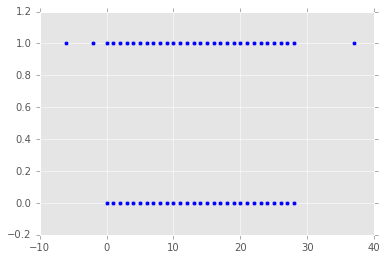

In [29]:
plt.scatter(policies.TenureInMonths, policies.Cancelled)

In [34]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)

feature_cols = ['MOnthsSinceLastClaim']
X = policies[feature_cols]
y = policies.Cancelled
logreg.fit(X, y)
policies_pred_class = logreg.predict(X)

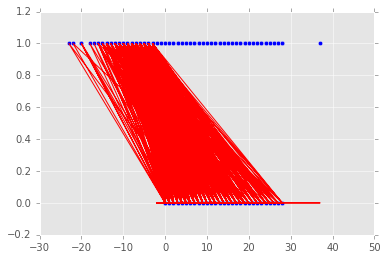

In [35]:
# plot the class predictions
plt.scatter(policies.MOnthsSinceLastClaim, policies.Cancelled)
plt.plot(policies.MOnthsSinceLastClaim, policies_pred_class, color='red')

In [32]:
policies_pred_prob = logreg.predict_proba(X)[:, 1]
policies_pred_prob

array([ 0.52505975,  0.52505975,  0.52505975, ...,  0.52505975,
        0.32502464,  0.35159242])

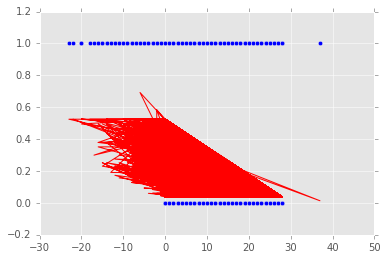

In [36]:
# plot the predicted probabilities
plt.scatter(policies.MOnthsSinceLastClaim, policies.Cancelled)
plt.plot(policies.MOnthsSinceLastClaim, policies_pred_prob, color='red')

In [81]:
#policies.dropna(inplace=True)
#policies.irsd_decile

In [67]:
#print logreg.predict_proba(11)

In [65]:
policies.describe()

,Cancelled,PlanType,ClaimedInThePast,BenefitToClaimRatio,irsd_decile,premium_payment_period_code,payment_method_code,InsuredGender,PremiumDecile,breed_risk_group,...,OtherMembershipNumber,species_code,State,OtherPets,MOnthsSinceLastClaim,LastClaimStatus,Ntile5LastClaimAmount,Ntile5LastPaidAmount,ClientAgeInGroup,PetAgeGroup
count,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,...,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000,265649.000000
mean,0.276041,1.546469,0.305877,0.115154,6.564877,1.563608,1.449168,1.272627,5.501835,0.681968,...,0.273218,1.154986,2.725713,0.818027,7.911782,1.411547,0.772568,0.940937,3.704561,3.776965
std,0.447038,0.670413,0.460779,0.235857,2.699829,0.675790,0.497441,0.445311,2.871830,1.504581,...,0.445613,0.361892,1.494620,1.550773,7.253663,0.713830,1.370200,1.653697,1.330299,2.743609
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,-23.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,1.000000,0.000000,0.000000,4.000000,1.000000,1.000000,1.000000,3.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,3.000000,2.000000
50%,0.000000,1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,1.000000,6.000000,0.000000,...,0.000000,1.000000,3.000000,0.000000,6.000000,1.000000,0.000000,0.000000,4.000000,3.000000
75%,1.000000,2.000000,1.000000,0.000000,9.000000,2.000000,2.000000,2.000000,8.000000,0.000000,...,1.000000,1.000000,4.000000,1.000000,12.000000,2.000000,1.000000,1.000000,5.000000,5.000000
max,1.000000,4.000000,1.000000,1.100062,10.000000,3.000000,3.000000,2.000000,10.000000,6.000000,...,1.000000,2.000000,8.000000,33.000000,37.000000,4.000000,5.000000,5.000000,6.000000,12.000000


In [69]:
feature_cols = ['species_code','irsd_decile',
                'State','OtherPets',
                'MOnthsSinceLastClaim','LastClaimStatus','Ntile5LastClaimAmount','Ntile5LastPaidAmount',
                'PortalUser','OtherMembershipNumber','ClientAgeInGroup','PetAgeGroup','PremiumDecile','InsuredGender',
                'payment_method_code','premium_payment_period_code','ClaimedInThePast','PlanType']
X = policies[feature_cols]
y = policies.Cancelled

In [70]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [53]:
#from sklearn.linear_model import LogisticRegression
#logreg = LogisticRegression()
#logreg.fit(X_train, y_train)
#zip(feature_cols, logreg.coef_[0])

[('species_code', 0.30094937249821491),
 ('State', 0.0087438204632062731),
 ('OtherPets', 0.14578165264027373),
 ('MOnthsSinceLastClaim', -0.12050756707968022),
 ('LastClaimStatus', -0.060098145971260702),
 ('Ntile5LastClaimAmount', -0.18742998248870804),
 ('Ntile5LastPaidAmount', 0.3213408162242522),
 ('PortalUser', -1.1023582143782436),
 ('OtherMembershipNumber', -0.51348521038242512),
 ('ClientAgeInGroup', -0.11354699476328341),
 ('PetAgeGroup', 0.036100702697428738),
 ('PremiumDecile', -0.0062567598376249275),
 ('InsuredGender', -0.033688543286080667),
 ('payment_method_code', -0.16510981121450324),
 ('premium_payment_period_code', -0.28926939303619936),
 ('ClaimedInThePast', -1.2445618803581611),
 ('PlanType', 0.23655941965830404)]

In [75]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
Cancelled_pred_class = logreg.predict_proba(X_train)[:, 1]
Cancelled_pred_class

array([ 0.35702614,  0.0457944 ,  0.38838773, ...,  0.13069242,
        0.42180219,  0.22062274])

In [76]:
import numpy as np
print 'no regularization =', np.sqrt(metrics.mean_squared_error(y_train, Cancelled_pred_class))

no regularization = 0.399247448023


In [80]:
from sklearn import metrics
prds = logreg.predict(X)
print metrics.confusion_matrix(y, prds)

[[177710  14609]
 [ 44436  28894]]


- Accuracy = (177710+28894)/265649 == 0.78
- Specificity = 177710 / (177710 + 14609) == 0.92

## Trying Regularization

In [79]:
from sklearn.linear_model import LassoCV
alpha_range = 10.**np.arange(-2, 3)
laspolicies = LassoCV(normalize=True, alphas=alpha_range)
laspolicies.fit(X_train, y_train)
laspolicies.alpha_
laspolicies.coef_
preds2 = laspolicies.predict(X_test)
print 'Lasso CV reg =', np.sqrt(metrics.mean_squared_error(y_test, preds2))

Lasso CV reg = 0.446459440556


**Ian**, if this is the mean square error, does this mean that the log reg with LASSO is predicting better than the one without? If the mean square error eh 44%, what exactly does it mean? :)

## Trying Principal Components

In [82]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition